# Loading Packages

In [1]:
import re 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.model_selection import train_test_split
import random 
import math
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.utils as torch_utils
from torch.utils.data import TensorDataset, DataLoader, Dataset
from tqdm import tqdm_notebook
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import torch.nn.functional as F
import d2l
import time
import traceback
import fastprogress
from torchmetrics.classification import BinaryAccuracy, Accuracy 
import torch.nn.init as init
import torch.optim.lr_scheduler as lr_scheduler
from itertools import repeat

In [2]:
seed = 100
torch.manual_seed(seed)
np.random.seed(seed)

In [3]:
# torch.cuda.is_available() checks and returns a Boolean True if a GPU is available, else it'll return False
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU
if is_cuda:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

# Loading Data (with scaling)

In [4]:
# Custom Dataset class for loading data
class MyDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        # Implement data retrieval for each index
        input_data = self.X[idx]
        target_data = self.y[idx]
        input_data = input_data.unsqueeze(0)
        
        # Convert data to torch tensors if required
        input_tensor = torch.Tensor(input_data)
        target_tensor = torch.Tensor(target_data)
        
        return input_tensor, target_tensor

In [5]:
#with scaling
df = pd.read_csv("C:/Users/kacpe/Desktop/study/research lab/data_model_v2.csv")
# List of column names to drop
columns_to_drop = ['lKnee_x','lKnee_y','lKnee_z','lAnkle_x','lAnkle_y','lAnkle_z','rKnee_x','rKnee_y','rKnee_z','rAnkle_x','rAnkle_y','rAnkle_z']
df = df.drop(columns=columns_to_drop)
#df = df[columns_to_keep]
# Step 1: Separate 'id' and 'trial' columns from the rest of the data
data_to_scale = df.drop(columns=['id', 'trial'])

# Step 2: Apply MinMaxScaler to the remaining columns
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data_to_scale)

# Convert the scaled data back to a DataFrame
scaled_df = pd.DataFrame(scaled_data, columns=data_to_scale.columns)

# Step 3: Merge 'id' and 'trial' columns with the scaled data
scaled_df[['id', 'trial']] = df[['id', 'trial']]

# Step 4: create variable t-1
# List of columns to shift
columns_to_shift = ['s_1', 's_2', 's_3','s_4']  # List all column names here

# Create shifted columns for each column in the list
for col in columns_to_shift:
    new_col_name = col + '_minus_1'
    scaled_df[new_col_name] = scaled_df[col].shift(1)
    scaled_df[new_col_name] = scaled_df[new_col_name].fillna(1)  # Fill NaN in the first row with 0
    scaled_df[new_col_name] = scaled_df[new_col_name].astype(int)

#desired_column_order = [col for col in scaled_df.columns if col not in columns_to_shift] + columns_to_shift
#scaled_df = scaled_df[desired_column_order]
selected_columns = ['id', 'trial','s_1_minus_1','s_2_minus_1','s_3_minus_1','s_4_minus_1','s_1','s_2','s_3','s_4']
scaled_df = scaled_df[selected_columns]

# Step 5: Split the data into training and test sets based on the 'trial' column
train_set = scaled_df[scaled_df['trial'].isin(range(1, 15))].drop(columns=['id', 'trial'])
test_set = scaled_df[scaled_df['trial']==15].drop(columns=['id', 'trial'])
val_set = scaled_df[scaled_df['trial']==16].drop(columns=['id', 'trial'])
full_set = scaled_df.drop(columns=['id','trial'])

# split data into x and y 
X_train, y_train = train_set.iloc[:,:-4], train_set.iloc[:,-4:]
X_test, y_test = test_set.iloc[:,:-4], test_set.iloc[:,-4:]
X_val, y_val = val_set.iloc[:,:-4], val_set.iloc[:,-4:]
X, y = full_set.iloc[:,:-4], full_set.iloc[:,-4:]

# Create custom datasets for training, validation, and testing
full_dataset = MyDataset(torch.tensor(X.values), torch.tensor(y.values))
train_dataset = MyDataset(torch.tensor(X_train.values), torch.tensor(y_train.values))
val_dataset = MyDataset(torch.tensor(X_val.values), torch.tensor(y_val.values))
test_dataset = MyDataset(torch.tensor(X_test.values), torch.tensor(y_test.values))

# Create a DataLoader
#batch_size = 5561#67  # Set your desired batch size
#shuffle = False  # Set to False to preserve the order of your data
fullset_dataloader = DataLoader(full_dataset, batch_size=X.shape[0], shuffle=False)
train_dataloader = DataLoader(train_dataset, batch_size=X_train.shape[0], shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=X_test.shape[0], shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=X_val.shape[0], shuffle=False)

# Model Architecture

In [6]:
class GRUNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers, drop_prob=0.2, bidirectional=False):
        super(GRUNet, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        
        self.gru = nn.GRU(input_dim, hidden_dim, n_layers, batch_first=True, dropout=drop_prob)
        self.gru = nn.GRUCell(input_dim, hidden_dim, bias=True)
        #Xavier initialization for GRU weights
        #for name, param in self.gru.named_parameters():
        #    if 'weight' in name:
        #        init.xavier_uniform_(param.data)
        #    elif 'bias' in name:
        #        init.constant_(param.data, 0.0)
                
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.sotfplus = nn.Softplus()
        self.relu = nn.ReLU()

        
        
    def forward(self, x, h):
        out, h = self.gru(x, h)
        out = self.fc(self.sotfplus(out[:,-1]))
        #out = self.fc(self.relu(out[:,-1]))
        out = F.softmax(out, dim=1)
        return out, h
    
    #def init_hidden(self, batch_size):
        #weight = next(self.parameters()).data
        #hidden = weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device)
        #return hidden
    def init_hidden(self, batch_size):
        if batch_size > 1:
            weight = next(self.parameters()).data
            hidden = weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device)
        else:
            weight = next(self.parameters()).data
            hidden = weight.new(self.n_layers, self.hidden_dim).zero_().to(device)
        return hidden

In [7]:
class GRUCellNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.gru = nn.GRUCell(input_dim, hidden_dim, bias=True)                
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.softplus = nn.Softplus()
        self.relu = nn.ReLU()

        self.gru_cells = nn.ModuleList([
            nn.GRUCell(input_dim, hidden_dim) if i == 0 else nn.GRUCell(hidden_dim, hidden_dim)
            for i in range(num_layers)
        ])
        self.batch_norm = nn.BatchNorm1d(hidden_dim)  # Add BatchNorm outside GRU cells

        
        
    def forward(self, x, h=None):
        if h is None:
            h = [torch.zeros(x.size(0), self.hidden_dim) for _ in range(self.num_layers)]
        
        hidden_states = []
        
        for t in range(x.size(1)):
            input_t = x[:, t, :]
            new_hidden_states = []
            for layer_idx, gru_cell in enumerate(self.gru_cells):
                h[layer_idx] = gru_cell(input_t, h[layer_idx])
                new_hidden_states.append(h[layer_idx])
                input_t = h[layer_idx]  # Update input_t with the new hidden state for the next layer
            hidden_states.append(new_hidden_states)
        
        last_hidden_states = [layer_states[-1] for layer_states in hidden_states]
        # Apply BatchNorm to the last hidden state
        last_hidden_states[-1] = self.batch_norm(last_hidden_states[-1])
        #all_hidden_states = torch.cat(hidden_states, dim=1)  # Stack all hidden states across time steps
        
        
        out = self.fc(self.softplus(last_hidden_states[-1]))
        #out = self.fc(self.softplus(all_hidden_states[:, -1]))  # Use the last hidden state for prediction
        #probs = torch.sigmoid(out)  # Apply sigmoid activation to get probabilities
        #preds = torch.round(probs)  # Convert probabilities to binary predictions
        #out = F.sigmoid(out, dim=1)
        
        return out, last_hidden_states 
    
    
    
    #def init_hidden(self, batch_size):
     #   return nn.Parameter(torch.zeros([batch_size, self.gru_cells[0].hidden_size]))

# Training functions

In [8]:
def accuracy(correct, total):
    return float(correct)/total

In [9]:
def train(dataloader, model, optimizer, loss_fn, scheduler=None, device=None):
    epoch_loss = []
    epoch_correct, epoch_total = 0, 0
    model = model.to(device)
    model.train()
    predicted_probs = []
    predicted_labels = []
    #hidden_states = []
    for x, y in dataloader:
        x = x.to(device).float()
        y = y.to(device).float()
        
        optimizer.zero_grad()
        
        out, last_hidden_states = model(x)
        y_prob = torch.sigmoid(out)
        # Append the predicted probabilities to the list
        predicted_probs.append(y_prob.cpu().detach().numpy())
        loss = loss_fn(out, y)
        epoch_loss.append(loss.item())

        #hidden_states.append(hidden)
        
        y_pred = torch.round(y_prob)
        epoch_correct += sum((y == y_pred).flatten()).item()
        epoch_total += y.numel()
        
        loss.backward()
        torch_utils.clip_grad_norm_(model.parameters(), max_norm=10)
        optimizer.step()

        predicted_labels.extend(zip(y_pred.cpu().detach().cpu().numpy(), y.cpu().numpy()))
        if scheduler:
            scheduler.step()
    
    return np.mean(epoch_loss), accuracy(epoch_correct, epoch_total), predicted_labels, predicted_probs 

In [10]:
def validate(dataloader, model, loss_fn, device=None):
    epoch_loss = []
    epoch_correct, epoch_total = 0, 0
    model = model.to(device).float()
    model.eval()
    predicted_probs = []
    predicted_labels = []
    #hidden_states = []
    with torch.no_grad():
        for x, y in dataloader:
            x = x.to(device).float()
            y = y.to(device).float()
            
            out, last_hidden_states = model(x)
            
            loss = loss_fn(out, y)
            epoch_loss.append(loss.item())

            #hidden_states.append(hidden)
            y_pred = torch.sigmoid(out)
            predicted_probs.append(y_pred.cpu().detach().numpy())
            y_pred = torch.round(y_pred)
            epoch_correct += sum((y == y_pred).flatten())
            epoch_total += y.numel()
            predicted_labels.extend(zip(y_pred.cpu().numpy(), y.cpu().numpy()))
    
    return np.mean(epoch_loss), accuracy(epoch_correct, epoch_total), predicted_labels, predicted_probs

In [11]:
def run_training(train_dataloader, val_dataloader, model, optimizer, loss_fn, num_epochs, scheduler=None, device=None, schedule_on_train=True, verbose=True):
    train_losses, train_accs = [], []
    val_losses, val_accs = [], []

    #train_hidden_states, val_hidden_states = [], []
    
    for epoch in range(num_epochs):
        epoch_train_loss, epoch_train_acc, train_preds, train_probs = train(train_dataloader, model, optimizer, loss_fn, scheduler, device)
        
        train_losses.append(epoch_train_loss)
        train_accs.append(epoch_train_acc)

        #train_hidden_states.extend(train_hidden)
        
        if val_dataloader is not None:
            epoch_val_loss, epoch_val_acc, val_preds, val_probs = validate(val_dataloader, model, loss_fn, device)
        
            val_losses.append(epoch_val_loss)
            val_accs.append(epoch_val_acc)

            #val_hidden_states.extend(val_hidden)
        
        #if isinstance(scheduler, ReduceLROnPlateau):
        #    scheduler.step(epoch_train_acc if schedule_on_train or val_dataloader is None else epoch_val_acc)
            
        if epoch % 50 == 0:
            val_str = f", val loss: {epoch_val_loss}, val acc: {epoch_val_acc}" if val_dataloader is not None else ""
            print(f"Epoch {epoch}, train loss: {epoch_train_loss}, train acc: {epoch_train_acc}{val_str}")
        if epoch == num_epochs - 1:  # Store values only for the final epoch
            train_predicted_labels = train_preds
            #val_predicted_labels = val_preds
            train_probs_final = train_probs
            #val_probs_final = val_probs
            if val_dataloader is not None:
                val_predicted_labels = val_preds
                val_probs_final = val_probs

    if val_dataloader is not None:        
        return train_losses, train_accs, val_losses, val_accs, train_predicted_labels, val_predicted_labels, train_probs_final, val_probs_final
    else: 
        return train_losses, train_accs, val_losses, val_accs, train_predicted_labels, train_probs_final

# Testing

In [12]:
X_train.shape

(6107, 4)

In [13]:

# Hyperparameters
input_dim = 4
hidden_dim = 4
output_dim = 4
num_layers = 1
n_epochs =500
lr = 0.01

# Create an instance of GRUCellNet
model = GRUCellNet(input_dim, hidden_dim, output_dim, num_layers)

# Define loss function and optimizer
class_weights = torch.tensor([1.8]).to(device)
loss_fn = nn.BCEWithLogitsLoss(pos_weight=class_weights)  
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.95)

In [14]:
train_losses, train_accs, val_losses, val_accs, train_predicted, val_predicted, train_probs, val_probs= run_training(
    train_dataloader, val_dataloader=val_dataloader, model=model, optimizer=optimizer, loss_fn=loss_fn, num_epochs=n_epochs, scheduler=scheduler)

Epoch 0, train loss: 1.1202812194824219, train acc: 0.4203782544620927, val loss: 0.9748719930648804, val acc: 0.5895522388059702
Epoch 50, train loss: 0.497305691242218, train acc: 0.8224168986409038, val loss: 0.5457884669303894, val acc: 0.8649253731343284
Epoch 100, train loss: 0.2963683605194092, train acc: 0.9312264614376945, val loss: 0.23328112065792084, val acc: 0.996268656716418
Epoch 150, train loss: 0.20646241307258606, train acc: 0.9591861797936794, val loss: 0.10956566780805588, val acc: 0.996268656716418
Epoch 200, train loss: 0.168293297290802, train acc: 0.9591861797936794, val loss: 0.07571794837713242, val acc: 0.996268656716418
Epoch 250, train loss: 0.14900805056095123, train acc: 0.9591861797936794, val loss: 0.06287651509046555, val acc: 0.996268656716418


KeyboardInterrupt: 

In [ ]:
# Assuming your model is named 'model'
state_dict = model.state_dict()
print(state_dict)

OrderedDict([('gru.weight_ih', tensor([[-0.3883,  0.3158, -0.2374, -0.0161],
        [ 0.1765,  0.2539, -0.2373, -0.4572],
        [-0.2920, -0.3820, -0.3783,  0.2356],
        [ 0.2118,  0.2876, -0.0817,  0.4014],
        [ 0.4969,  0.2565, -0.2761, -0.1977],
        [-0.3216,  0.3238,  0.0557,  0.4770],
        [-0.0560,  0.4478,  0.2445, -0.0108],
        [-0.2574,  0.2003,  0.0277, -0.2528],
        [ 0.2909, -0.0765, -0.4831, -0.2791],
        [ 0.4535,  0.2064, -0.3371,  0.3902],
        [ 0.0163, -0.4641,  0.1476, -0.1570],
        [-0.1818,  0.0261, -0.4553,  0.0123]])), ('gru.weight_hh', tensor([[ 0.4051,  0.0989, -0.0550,  0.2278],
        [-0.0437, -0.1611,  0.1211,  0.0530],
        [ 0.1896, -0.1313,  0.4053,  0.3356],
        [-0.1961,  0.1726,  0.0740,  0.4233],
        [ 0.4178,  0.2590,  0.2775,  0.1179],
        [-0.1621, -0.2830,  0.4454,  0.2116],
        [-0.3843,  0.1574, -0.1549, -0.4547],
        [ 0.4798,  0.0548,  0.1868, -0.0080],
        [-0.4252,  0.4605, -

In [ ]:
# Assuming your model is named 'model'
full_model = 'model_standard20.pth'
#torch.save(model.state_dict(), full_model)

In [15]:
# Load the saved weights into the model
#torch.save(model.state_dict(), 'model_weights.pth')
#model = GRUCellNet(input_dim, hidden_dim, output_dim, num_layers)
model.load_state_dict(torch.load('baseline_model.pth'))
model.eval()  # Set the model in evaluation mode
#gowno

GRUCellNet(
  (gru): GRUCell(4, 4)
  (fc): Linear(in_features=4, out_features=4, bias=True)
  (softplus): Softplus(beta=1, threshold=20)
  (relu): ReLU()
  (gru_cells): ModuleList(
    (0): GRUCell(4, 4)
  )
  (batch_norm): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [16]:
# Forward pass to get predictions
model.eval()
epoch_loss, accuracy, predicted_labels, predicted_probs = validate(test_dataloader,model,loss_fn)
predicted_labels

[(array([0., 1., 0., 0.], dtype=float32),
  array([1., 1., 1., 1.], dtype=float32)),
 (array([1., 1., 1., 1.], dtype=float32),
  array([1., 1., 1., 1.], dtype=float32)),
 (array([1., 1., 1., 1.], dtype=float32),
  array([1., 1., 1., 1.], dtype=float32)),
 (array([1., 1., 1., 1.], dtype=float32),
  array([1., 1., 1., 1.], dtype=float32)),
 (array([1., 1., 1., 1.], dtype=float32),
  array([1., 1., 1., 1.], dtype=float32)),
 (array([1., 1., 1., 1.], dtype=float32),
  array([1., 1., 1., 1.], dtype=float32)),
 (array([1., 1., 1., 1.], dtype=float32),
  array([1., 1., 1., 1.], dtype=float32)),
 (array([1., 1., 1., 1.], dtype=float32),
  array([1., 1., 1., 1.], dtype=float32)),
 (array([1., 1., 1., 1.], dtype=float32),
  array([1., 1., 1., 1.], dtype=float32)),
 (array([1., 1., 1., 1.], dtype=float32),
  array([1., 1., 1., 1.], dtype=float32)),
 (array([1., 1., 1., 1.], dtype=float32),
  array([1., 1., 1., 1.], dtype=float32)),
 (array([1., 1., 1., 1.], dtype=float32),
  array([1., 1., 1., 1.

Predictions

In [17]:
model.load_state_dict(torch.load('baseline_model.pth'))  # Load saved weights
model.eval()  # Set the model to evaluation mode
# Initialize an empty list to store predictions
all_predictions = []
all_probs = []

# Iterate through the test data batches
for inputs, _ in test_dataloader:
    inputs = inputs.float()
    # Forward pass to get predictions
    with torch.no_grad():
        predictions, _ = model(inputs)
        probabilities = torch.sigmoid(predictions)
        preds = torch.round(probabilities)

    # Append predictions to the list
    all_predictions.append(preds)
    all_probs.append(probabilities)

# Concatenate the predicted batches
all_predictions = torch.cat(all_predictions, dim=0)

In [ ]:
# Convert the tensor of predictions to a DataFrame
predictions_df = pd.DataFrame(all_predictions.numpy(), columns=y_test.columns, index=y_test.index)
# Calculate accuracy for each output state
accuracies = (predictions_df == y_test).mean()

print("Accuracy for each output state:")
print(np.mean(accuracies))

Accuracy for each output state:
0.9970588235294118


In [ ]:
np.arange(X_test.shape[0])

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

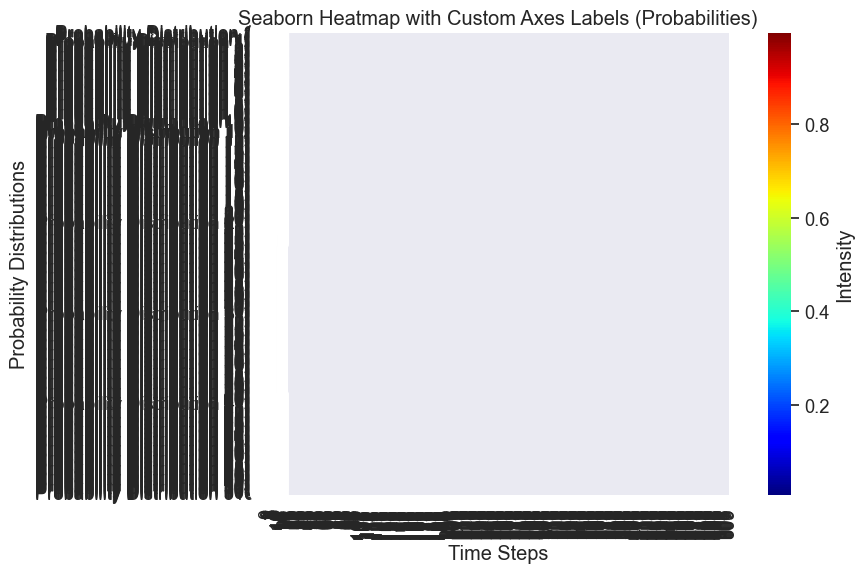

In [28]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Replace these with your actual data
timesteps = np.arange(510)  # Replace with your time step values

# Create a Seaborn heatmap using the data
sns.set(font_scale=1.2)  # Adjust font size as needed
plt.figure(figsize=(10, 6))  # Adjust figure size as needed
sns.heatmap(
    all_probs_array,
    cmap='jet',
    xticklabels=timesteps,
    yticklabels=[f'Probability Distribution {i+1}' for i in range(510)],
    annot=True,  # Display values on the heatmap
    fmt=".2f",  # Format values with two decimal places
    linewidths=0.5,
    square=True,
    cbar_kws={'label': 'Intensity'},
)

# Add labels and a title
plt.xlabel("Time Steps")
plt.ylabel("Probability Distributions")
plt.title("Seaborn Heatmap with Custom Axes Labels (Probabilities)")

# Show the plot
plt.show()

In [27]:
all_probs_array = torch.cat(all_probs,dim=0)
all_probs_array = all_probs_array.numpy()